# Samsung Electronics

## Data Load

In [393]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

2.1.4
1.3.0
0.14.0


In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = '/Users/yangdong-yeong/Desktop/프로젝트/Stock_Time_Series_ Regression/005930.KS (1).csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

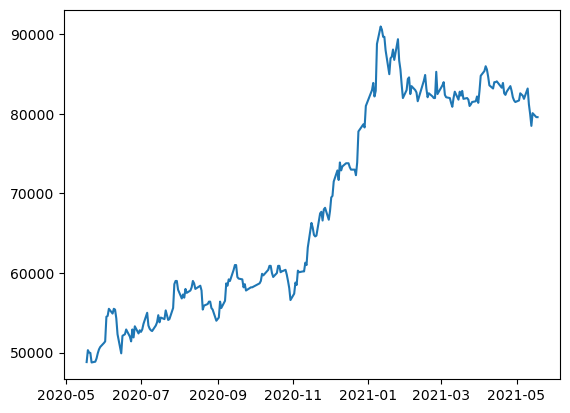

In [395]:
plt.plot(ts)

## Data Processing

In [396]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

결측치는 없는 것으로 확인됩니다.

In [397]:
# 함수 정의
from statsmodels.tsa.stattools import adfuller

# ADF Test
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# 
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

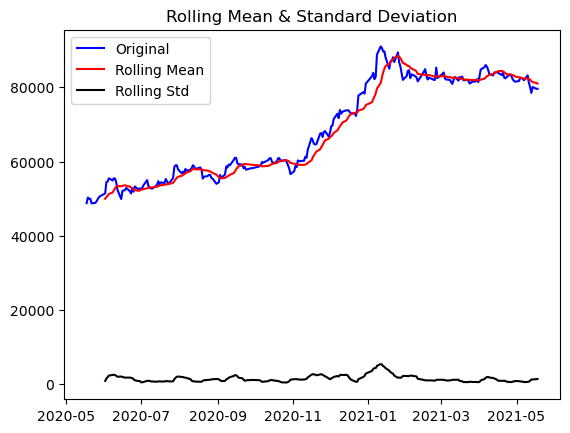

In [398]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [399]:
# 로그 변환
ts_log = np.log(ts)

In [400]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


log화 되었어도 정상성 데이터로 보기 어려워 보입니다.

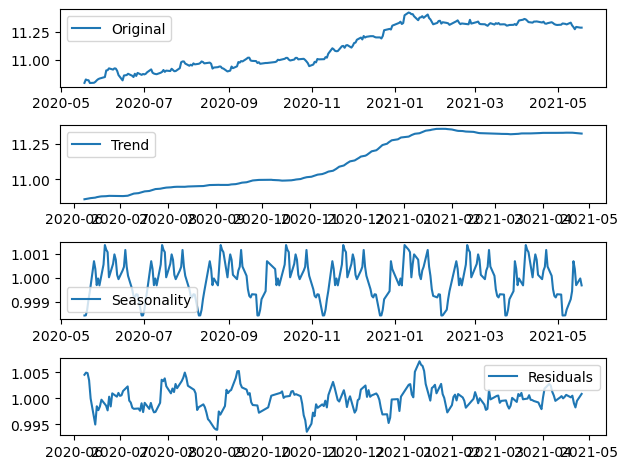

In [401]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Trend : 일정하지 않지만 시간이 지남에 따라 상승하는 추세를 볼 수 있습니다.
- Seasonality : 기간이 일정하지 않지만 정기적인 변동성이 보여집니다.
- Residuals : 잔차가 작고 불규칙한 것으로 보입니다.

In [402]:
# residuals 결측치 제거
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


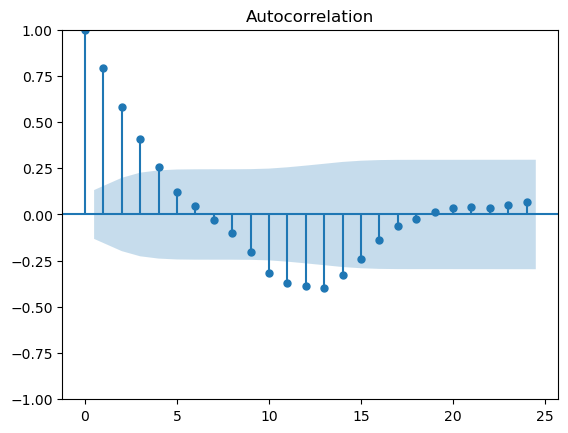

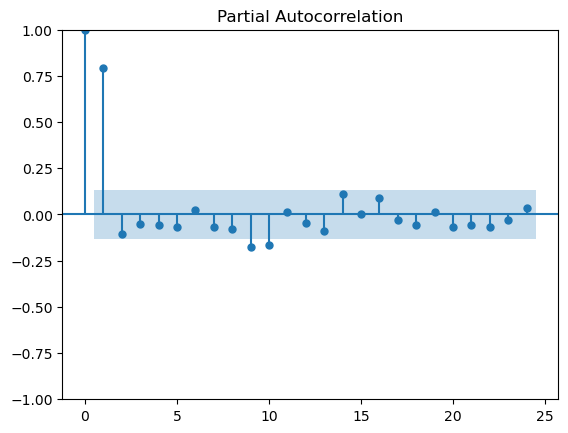

In [403]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residual)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(residual)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

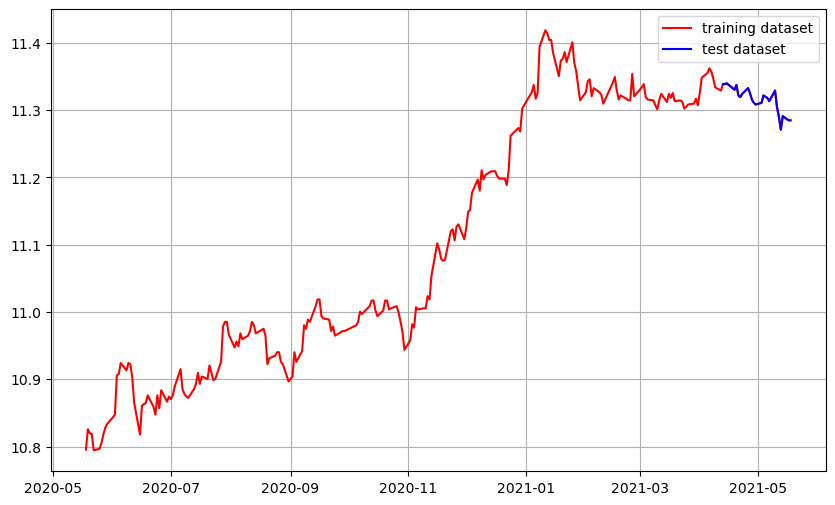

In [404]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Identify Model to be Tentatively Entertained

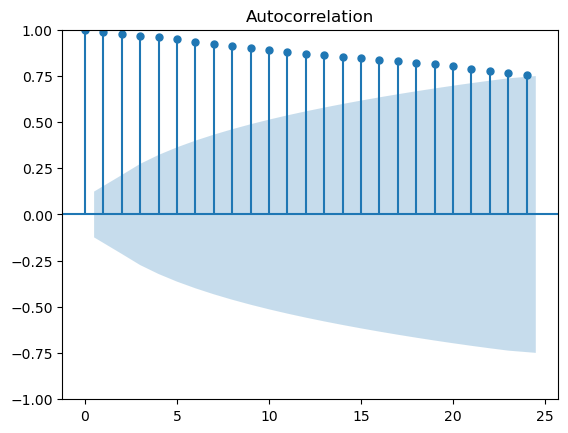

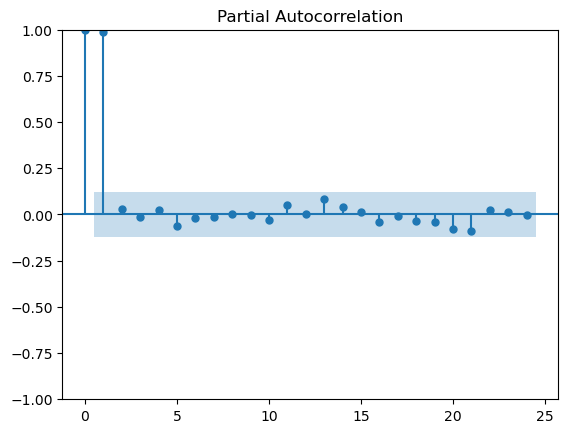

In [405]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF : 점차 감소하는 모습이 보여집니다.
- PACF : lag 1에서 급격하게 감소하는 것을 확인할 수 있습니다.

위 데이터는 위에서 확인했던 것과 같이 비정상성 데이터임을 확인할 수 있습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


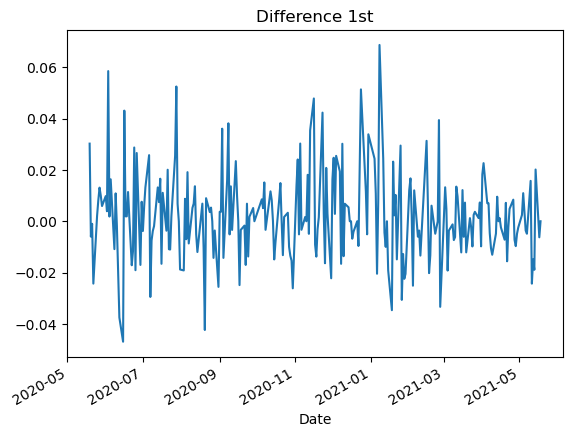

In [406]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분만으로 정상성 시계열 데이터로 보여집니다.

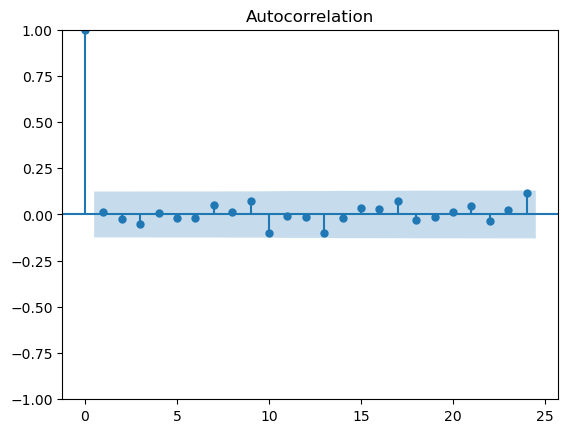

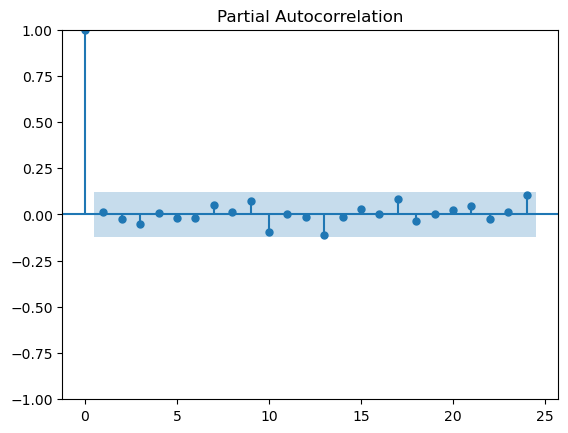

In [407]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 ACF와 PACF의 값이 모두 0 이후 급격한 감소로 확인되어 우선 ARMA(0,0)으로 적용해보겠습니다.

In [408]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Tue, 05 Mar 2024   AIC                          -1164.726
Time:                        15:49:11   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

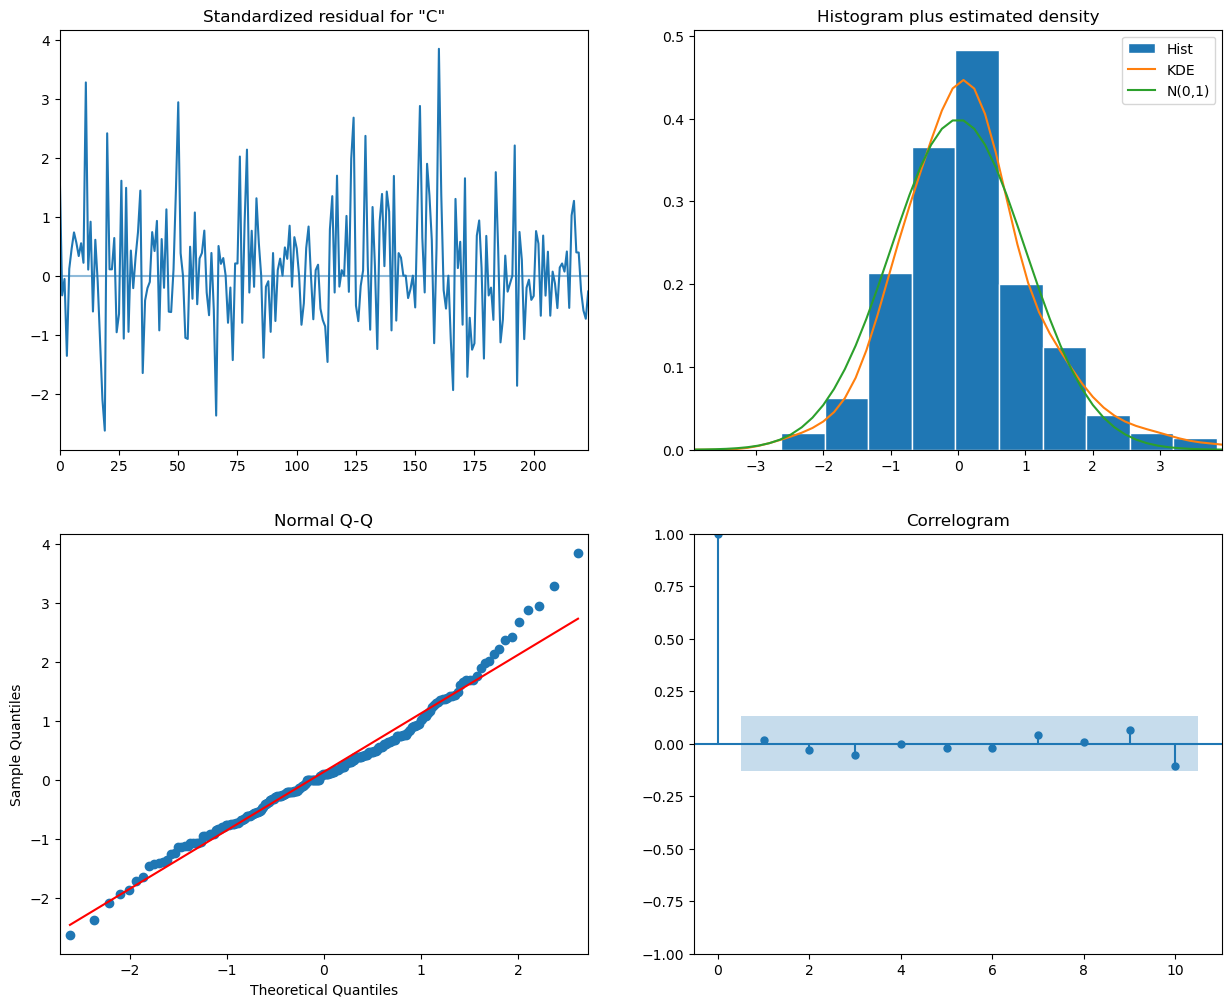

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


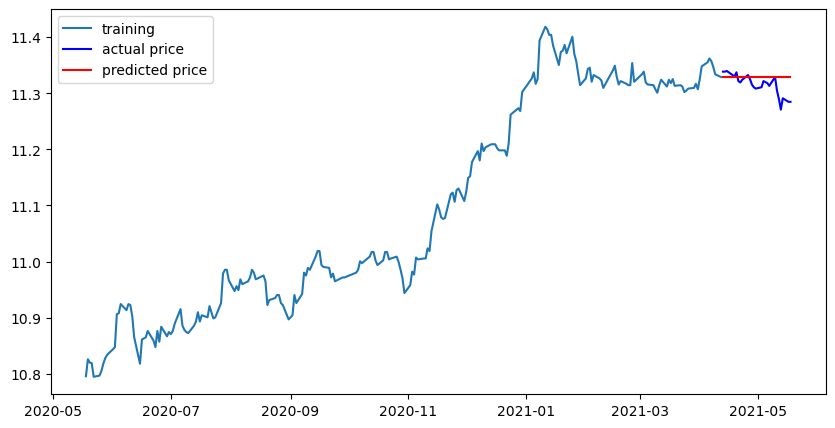

In [409]:
fitted_m.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [410]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


## Estimate Parameters

In [411]:
# Auto ARIMA
from pmdarima import auto_arima

In [412]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',       # ADF 검정을 사용하여 d를 결정
                   max_p=5, max_q=5, # 최대 p와 q 값
                   m=1,              # 계절성 주기, 여기서는 비계절성 데이터로 가정
                   d=None,           # d 값 자동 결정
                   seasonal=False,   # 계절성 여부, 여기서는 계절성이 없다고 가정
                   start_P=0, 
                   D=0, 
                   trace=True,       # 실행 과정 출력
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=False)    # 단계별 알고리즘 사용

# 최적의 모델 요약 출력
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1162.950, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1161.615, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1159.616, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1157.728, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1160.941, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1159.493, Time=0.04 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1157.623, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1162.974, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1160.969, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1159.385, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1157.129, Time=0.06

Auto ARIMA로 확인하였을 때도 0,1,0이 best model로 탐색되었습니다. <br/>
실제 예측 결과를 확인하였을 때 모델은 횡보할 것으로 예측하였지만 실제로는 주식 가격이 횡보하던 매물대에서 이탈하며 강한 하락으로 이어져 아쉬운 결과를 보였습니다.<br/>
<br/>
d = 0으로도 바꾸어 탐색해보겠습니다.

In [413]:
# d = 0으로 바꾸어 탐색
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',       # ADF 검정을 사용하여 d를 결정
                   max_p=5, max_q=5, # 최대 p와 q 값
                   m=1,              # 계절성 주기, 여기서는 비계절성 데이터로 가정
                   d=0,           # d 값 자동 결정
                   seasonal=False,   # 계절성 여부, 여기서는 계절성이 없다고 가정
                   start_P=0, 
                   D=0, 
                   trace=True,       # 실행 과정 출력
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=False)    # 단계별 알고리즘 사용

# 최적의 모델 요약 출력
print(model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1723.291, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1153.336, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1151.285, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1140.113, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1145.176, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1144.407, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Tim

In [414]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Tue, 05 Mar 2024   AIC                          -1158.741
Time:                        15:49:17   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


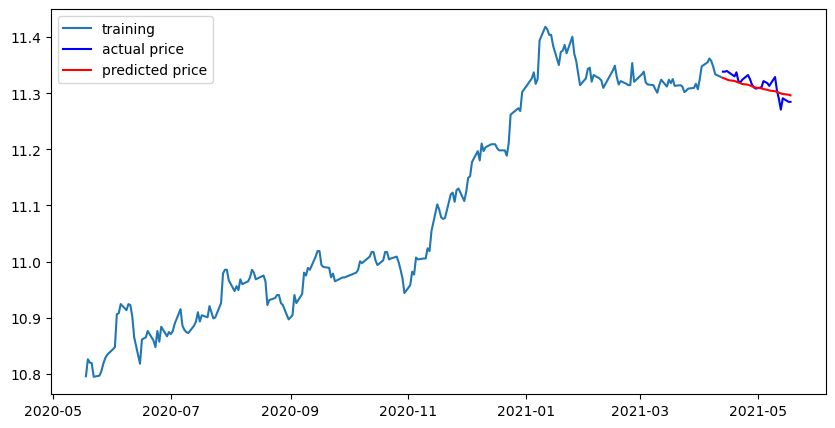

In [415]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [416]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1057119.8161343227
MAE:  850.8270312483428
RMSE:  1028.1633217219542
MAPE: 1.04%


오히려 차분을 진행하지 않았을 때 더 좋은 성능을 확인할 수 있었습니다. <br/>
<br/>
SARIMA로도 진행해보겠습니다, 일 단위 데이터로 m=7 로 시도해보겠습니다.

In [417]:
# auto_arima 함수 실행
model = auto_arima(ts_log, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=7,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# 결과 출력
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1122.870, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1176.023, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-1120.977, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-1207.209, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=-1249.246, Time=0.86 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-1250.937, Time=0.44 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-1208.843, Time=0.25 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-1177.614, Time=0.0

In [418]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(2, 1, 1, 7))
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42847D+00    |proj g|=  2.60495D+00

At iterate    5    f= -2.42935D+00    |proj g|=  1.31731D+00

At iterate   10    f= -2.44162D+00    |proj g|=  4.85186D+00

At iterate   15    f= -2.44392D+00    |proj g|=  3.63548D-01

At iterate   20    f= -2.45147D+00    |proj g|=  1.86939D-01

At iterate   25    f= -2.45655D+00    |proj g|=  1.01080D+00

At iterate   30    f= -2.47744D+00    |proj g|=  8.26962D-01

At iterate   35    f= -2.47764D+00    |proj g|=  2.53791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


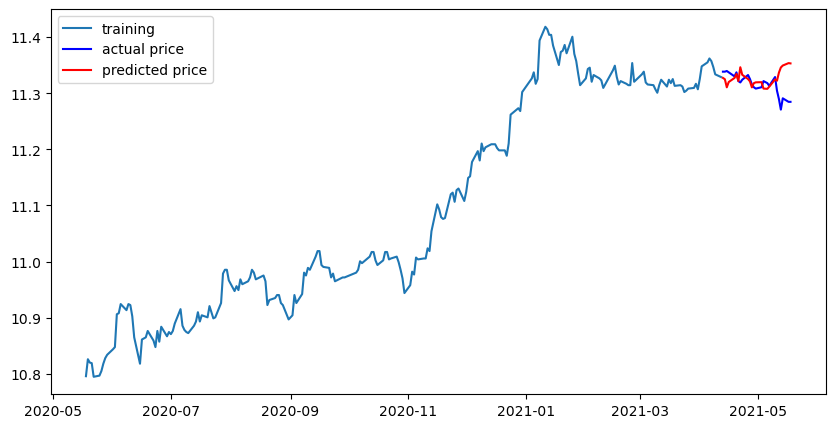

In [372]:
# Forecast : 결과가 fc에 담깁니다. 
fc = results.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [419]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1057119.8161343227
MAE:  850.8270312483428
RMSE:  1028.1633217219542
MAPE: 1.04%


# BTC

In [420]:
dataset_filepath = '/Users/yangdong-yeong/Desktop/프로젝트/Stock_Time_Series_ Regression/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

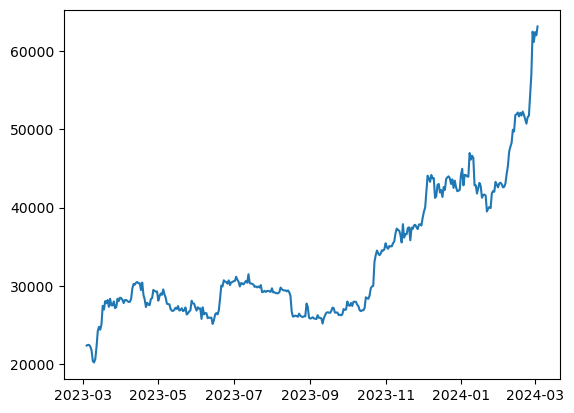

In [421]:
plt.plot(ts)

## Data Processing

In [422]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

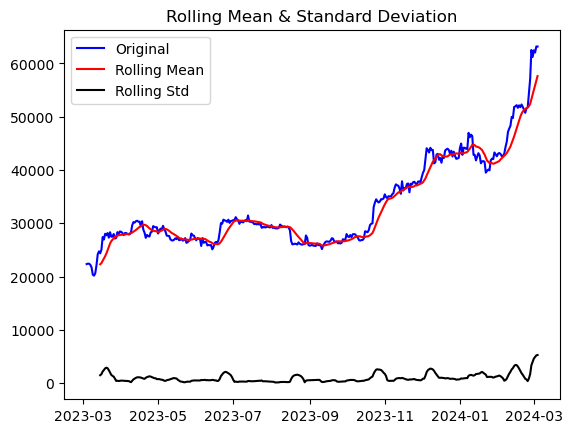

In [423]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [424]:
# 로그 변환
ts_log = np.log(ts)

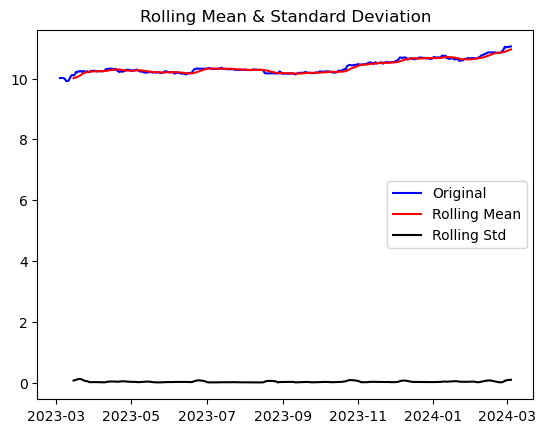

In [425]:
plot_rolling_statistics(ts_log, window=12)

In [426]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.326608
p-value                          0.978533
#Lags Used                       2.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


log화 되었어도 p-value가 0.97로 높습니다.

- Trend : 일정하지 않지만 시간이 지남에 따라 상승하는 추세를 볼 수 있습니다.
- Seasonality : 기간이 일정하지 않지만 정기적인 변동성이 보입니다.
- Residuals : 잔차가 작고 불규칙한 것으로 보입니다.

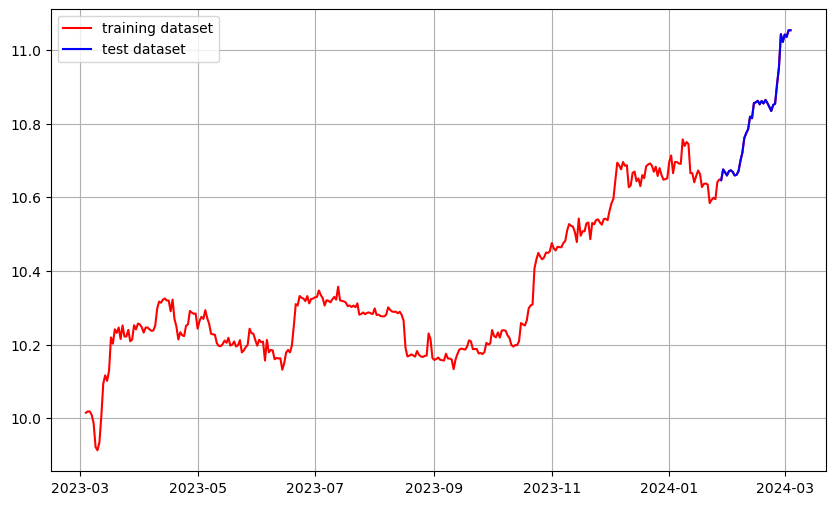

In [427]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Identify Model to be Tentatively Entertained

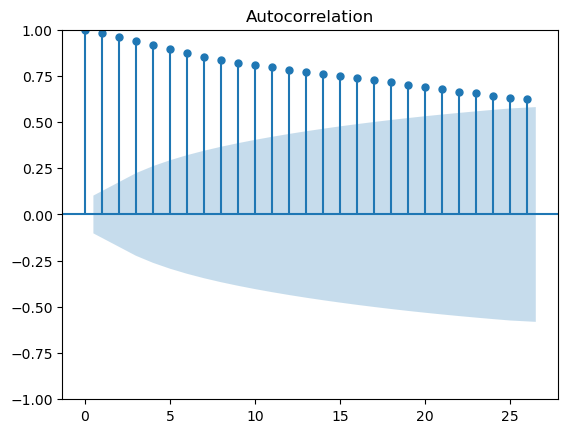

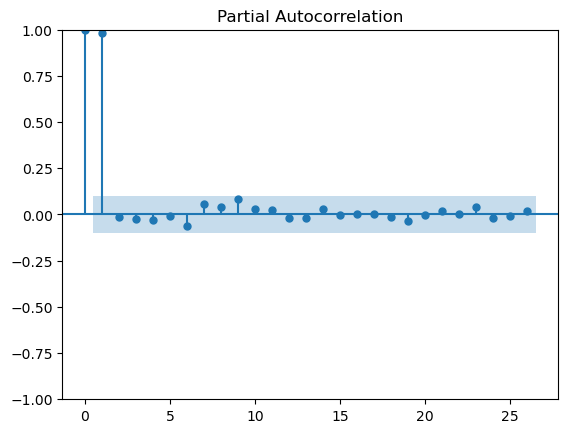

In [428]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF : 점차 감소하는 모습이 보여집니다.
- PACF : lag 1에서 급격하게 감소하는 것을 확인할 수 있습니다.

위 데이터는 위에서 확인했던 것과 같이 비정상성 데이터임을 확인할 수 있습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.204759e+01
p-value                        2.642783e-22
#Lags Used                     1.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


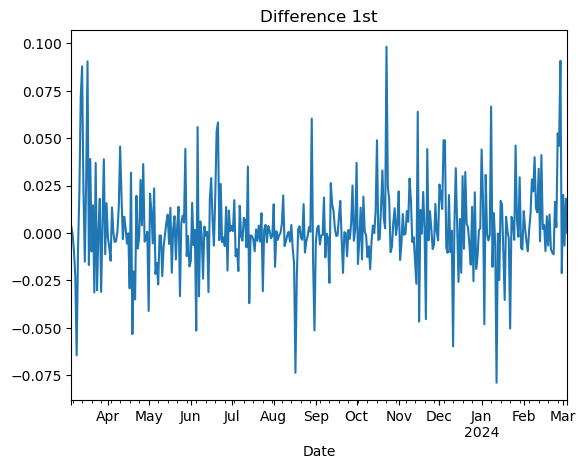

In [429]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분만으로 정상성 시계열 데이터로 보여집니다.

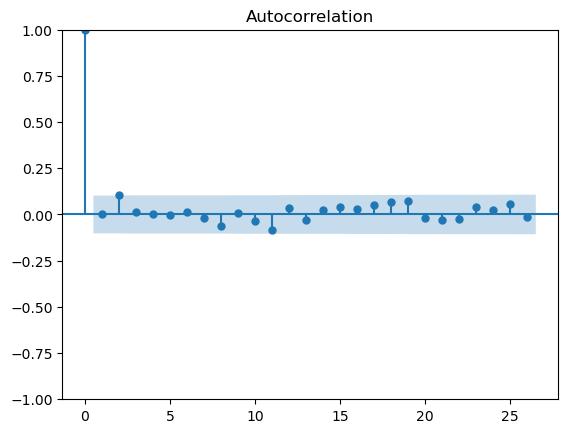

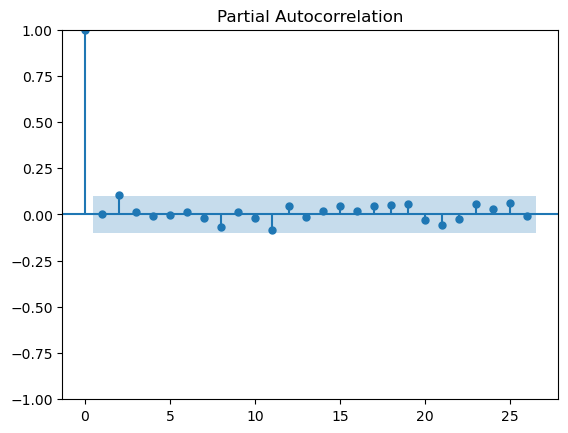

In [430]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 ACF와 PACF의 값이 모두 0 이후 급격한 감소로 확인되어 우선 ARMA(0,0)으로 적용해보겠습니다.

In [431]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  330
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 775.067
Date:                Tue, 05 Mar 2024   AIC                          -1548.134
Time:                        15:50:02   BIC                          -1544.338
Sample:                    03-04-2023   HQIC                         -1546.619
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   2.58e-05     20.384      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               129.73
Prob(Q):                              0.69   Pr

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


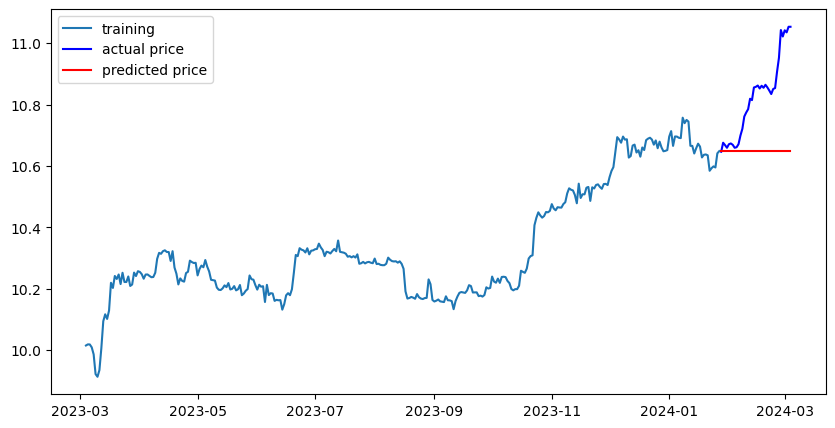

In [432]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [433]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  113590130.67146966
MAE:  8372.195417729694
RMSE:  10657.867078898556
MAPE: 15.21%


In [434]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',       # ADF 검정을 사용하여 d를 결정
                   max_p=5, max_q=5, # 최대 p와 q 값
                   m=1,              # 계절성 주기, 여기서는 비계절성 데이터로 가정
                   d=None,           # d 값 자동 결정
                   seasonal=False,   # 계절성 여부, 여기서는 계절성이 없다고 가정
                   start_P=0, 
                   D=0, 
                   trace=True,       # 실행 과정 출력
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=False)    # 단계별 알고리즘 사용

# 최적의 모델 요약 출력
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1548.460, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1546.600, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1546.144, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1544.161, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1542.209, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1540.274, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1546.618, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1544.640, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1544.157, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1539.587, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1540.216, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1546.086, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1544.116, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1542.195, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1539.702, Time=0.12

Auto ARIMA로 확인하였을 때도 0,1,0이 best model로 탐색되었습니다. <br/>
<br/>
차분을 진행하지 않았을 때 ACF, PACF를 참고하여 모델을 만들어보겠습니다.

In [435]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  330
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 774.980
Date:                Tue, 05 Mar 2024   AIC                          -1543.961
Time:                        15:50:10   BIC                          -1532.564
Sample:                    03-04-2023   HQIC                         -1539.415
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3349      0.101    102.153      0.000      10.137      10.533
ar.L1          0.9921      0.005    187.511      0.000       0.982       1.002
sigma2         0.0005   2.67e-05     19.761      0.0

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


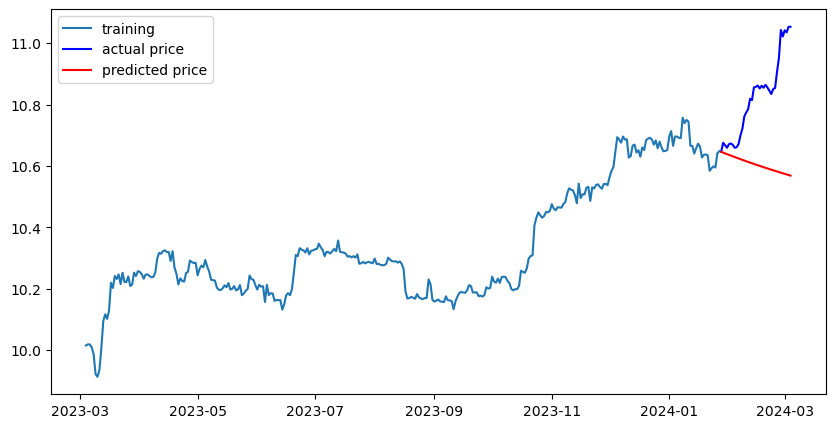

In [436]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

비트코인에서는 반대방향으로 예측하여 결과가 더 나빠졌습니다. <br/>
<br/>
이번에도 SARIMA를 적용해보겠습니다.

In [437]:
# auto_arima 함수 실행
model = auto_arima(ts_log, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=7,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# 결과 출력
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1441.926, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1550.781, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-1439.975, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-1580.692, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=-1660.069, Time=1.32 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=-1661.954, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-1662.015, Time=1.32 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-1663.897, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.2

In [438]:
model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(0, 1, 2, 7))
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.25047D+00    |proj g|=  2.51814D+00

At iterate    5    f= -2.25133D+00    |proj g|=  2.25440D-01

At iterate   10    f= -2.25242D+00    |proj g|=  1.95448D+00

At iterate   15    f= -2.25333D+00    |proj g|=  3.40321D-02

At iterate   20    f= -2.25526D+00    |proj g|=  1.14414D+00

At iterate   25    f= -2.26489D+00    |proj g|=  3.94269D-01

At iterate   30    f= -2.26508D+00    |proj g|=  6.95490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


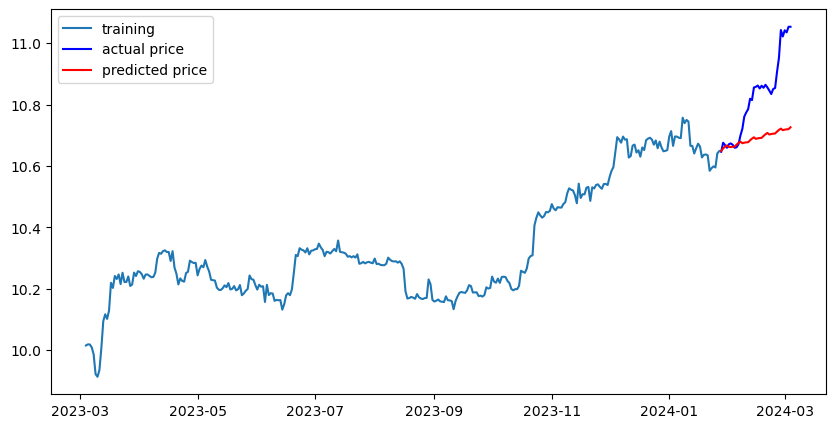

In [439]:
# Forecast : 결과가 fc에 담깁니다. 
fc = results.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [440]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  76112263.7417908
MAE:  6642.306801712394
RMSE:  8724.234278249914
MAPE: 11.97%


SARIMA를 적용했을 때 상승 방향을 맞췄으나 최근 너무 가파르게 상승하여 정확하게 예측하기는 어려워 보입니다.

# TSLA

In [441]:
dataset_filepath = '/Users/yangdong-yeong/Desktop/프로젝트/Stock_Time_Series_ Regression/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

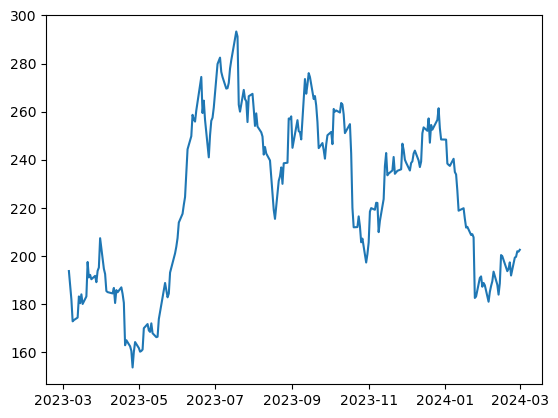

In [442]:
plt.plot(ts)

## Data Processing

In [443]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

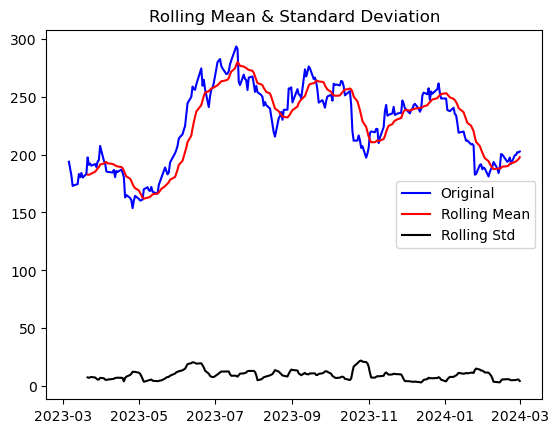

In [444]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [445]:
# 로그 변환
ts_log = np.log(ts)

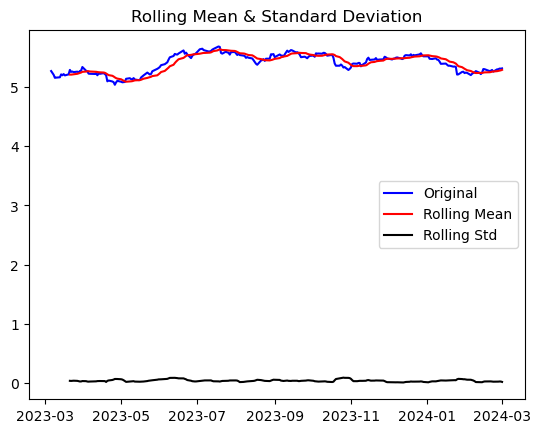

In [446]:
plot_rolling_statistics(ts_log, window=12)

In [447]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.202071
p-value                          0.205495
#Lags Used                       8.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


log화 되었어도 p-value가 0.20로 높습니다.

- Trend : 일정하지 않지만 시간이 지남에 따라 상승하는 추세를 볼 수 있습니다.
- Seasonality : 기간이 일정하지 않지만 정기적인 변동성이 보입니다.
- Residuals : 잔차가 작고 불규칙한 것으로 보입니다.

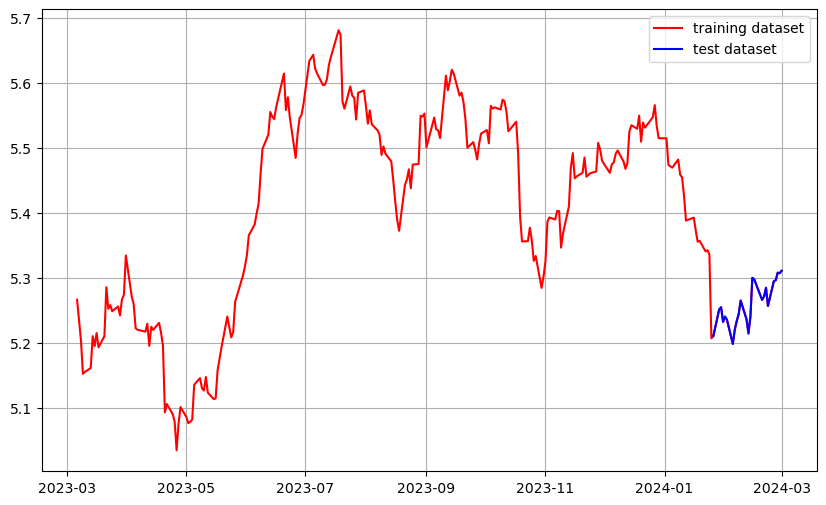

In [448]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Identify Model to be Tentatively Entertained

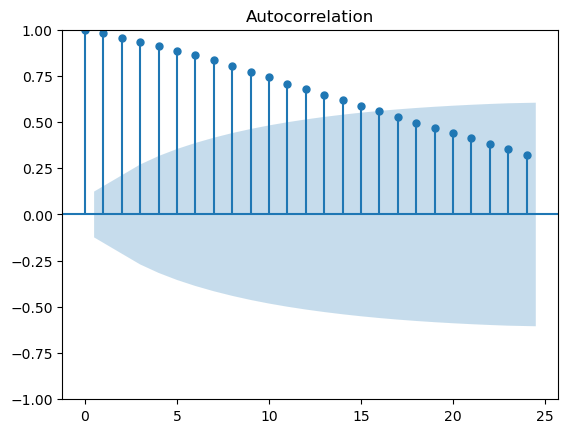

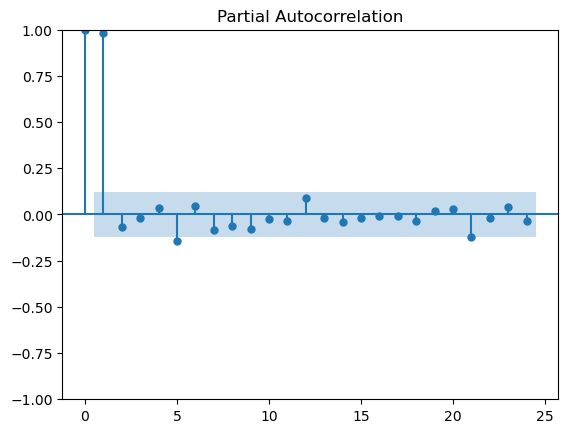

In [449]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF : 점차 감소하는 모습이 보여집니다.
- PACF : lag 1에서 급격하게 감소하는 것을 확인할 수 있습니다.

위 데이터는 위에서 확인했던 것과 같이 비정상성 데이터임을 확인할 수 있습니다.

Results of Dickey-Fuller Test:
Test Statistic                  -5.484292
p-value                          0.000002
#Lags Used                       5.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


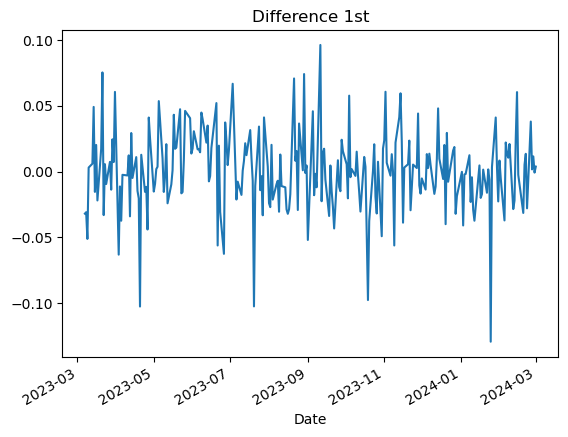

In [450]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분만으로 정상성 시계열 데이터로 보여집니다.

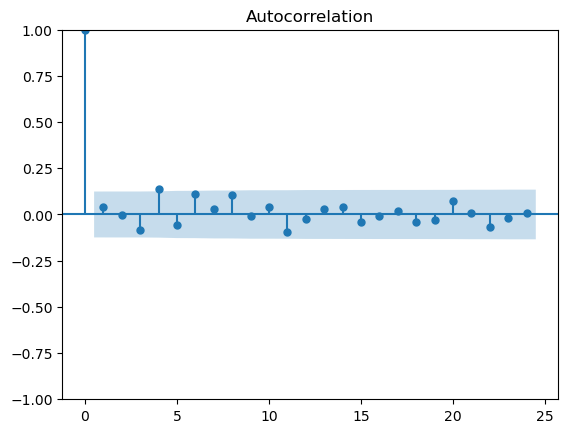

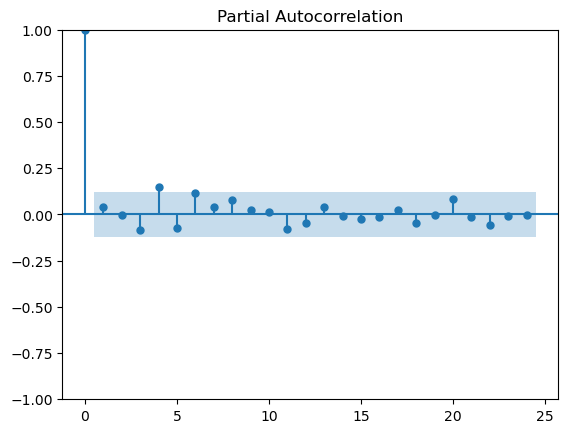

In [451]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 ACF와 PACF의 값이 모두 0 이후 급격한 감소로 확인되어 우선 ARMA(0,0)으로 적용해보겠습니다.

In [452]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 460.736
Date:                Tue, 05 Mar 2024   AIC                           -919.473
Time:                        15:55:31   BIC                           -916.061
Sample:                             0   HQIC                          -918.096
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0010   6.36e-05     15.038      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                43.63
Prob(Q):                              0.46   Pr

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


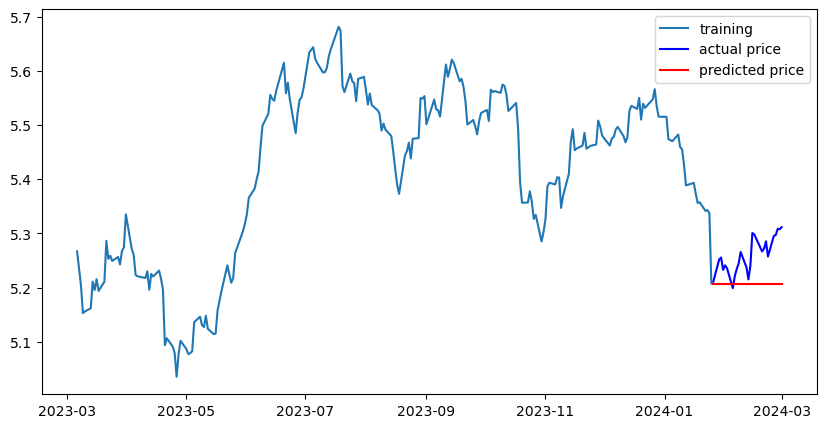

In [453]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [454]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  136.94856921924693
MAE:  9.95799552000003
RMSE:  11.702502690418275
MAPE: 5.08%


In [455]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 462.280
Date:                Tue, 05 Mar 2024   AIC                           -918.560
Time:                        15:55:35   BIC                           -908.311
Sample:                             0   HQIC                          -914.423
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3536      0.123     43.357      0.000       5.112       5.596
ar.L1          0.9829      0.013     73.967      0.000       0.957       1.009
sigma2         0.0009   6.34e-05     14.937      0.0

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


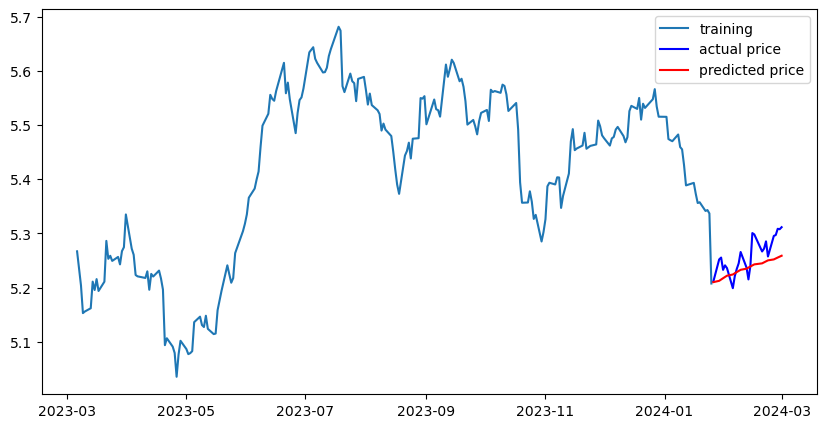

In [456]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [457]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  41.39769749752277
MAE:  5.308603457689184
RMSE:  6.434104249817746
MAPE: 2.71%


이번에도 차분을 진행하지 않았을 때의 ACF, PACF를 참고하여 ARIMA에 적용할 때 더 좋은 성과를 확인할 수 있습니다.

In [458]:
# auto_arima 함수 실행
model = auto_arima(ts_log, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=7,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# 결과 출력
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-842.199, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-908.409, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-841.437, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-929.145, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-930.963, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-910.358, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-957.150, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.81 sec
 ARIMA(

In [460]:
model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87250D+00    |proj g|=  4.95272D-01

At iterate    5    f= -1.87378D+00    |proj g|=  1.42573D+00

At iterate   10    f= -1.88129D+00    |proj g|=  8.27653D-02

At iterate   15    f= -1.88435D+00    |proj g|=  9.61354D-01

At iterate   20    f= -1.91051D+00    |proj g|=  9.10701D-02

At iterate   25    f= -1.91740D+00    |proj g|=  1.82509D-01

At iterate   30    f= -1.91784D+00    |proj g|=  2.04787D-01

At iterate   35    f= -1.91789D+00    |proj g|=  5.37138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yangdong-yeong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


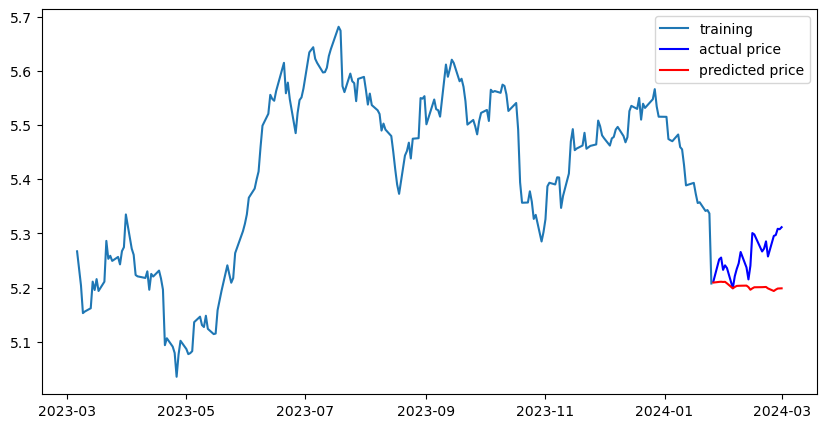

In [461]:
# Forecast : 결과가 fc에 담깁니다. 
fc = results.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

# Retrospective

**의문점**
1. 3가지 종목 모두 1차 차분 후 ACF와 PCAF 가 비슷한 형태를 가짐
2. 차분 후 예측력이 떨어짐

출처 : https://www.youtube.com/watch?v=ma_L2YRWMHI&t=1179s <br/>
김성범 교수님의 동영상을 참고하여 진행해보았는데 예상했던 것과 다른 점이 많아 궁금한 점이 많아졌다.<br/>
진행하고 보니 과거 삼성전자 데이터를 제외하고 최근 주식 시장에서 급격한 상승이 있던 종목들 예측하기 어려운 점도 영향이 있었을 것 같다.<br/>
<br/>
이번 과정을 통해 AFC,PACF, ADF에 대해 익숙해졌고 Trend와 Seasonality 차분을 통한 정상성 데이터를 만드는 과정에 대해 이해가 되었다.<br/>
아직 ARIMA와 SARIMA를 깊게 이해하지 못해 시행착오가 많았지만 그 과정에서 공부해야할 과정들을 알 수 있어 부족했던 부분들을 채워나가야겠다.<br/>